<a href="https://colab.research.google.com/github/KLAU-S/SRIP2022/blob/main/Q3altalt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary packages and modules

In [8]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

INIT MLP Fuction

In [9]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):#making the standard deviation smaller by a factor of 100

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1) #using jax.random.split to create key

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)), #sample data from normal distribution, its a convention to use out_width first
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params)) #here using tree map fuctionality from jax in order to understand if it is correct

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


Now we can create MLP_predict function

In [10]:
def MLP_predict(params, x):
    hidden_layers = params[:-1] #the first two layers

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last #last layer will not have relu, ie logits
    # the optimization is done here instead of sigmoid we used logsumxp
      # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
      # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

# testing our prediction function
img_flat = np.random.randn(16, np.prod(mnist_img_size))
print(img_flat.shape)
predictions = batched_MLP_predict(MLP_params, img_flat)
print(predictions.shape)

(16, 784)
(16, 10)


In [15]:
def custom_transform(x): # this converts the img data imported from torvision into numpy array
    return np.ravel(np.array(x, dtype=np.float32)) #ravel to flatten the img

def custom_collate_fn(batch): #pytorch by default creates a tesor if we do not collate
    transposed_data = list(zip(*batch)) #basically we want all of the images batched into sinle numpy array and separate the labels

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0]) #np.array will work too

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform) 

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

(128, 784) float32 (128,) int64


In [12]:
# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

Training loop function

In [13]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs) #if pred-->1; log(pred)-->0, basically to achieve numerical stability of cross-entropy loss

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader): #imgs is handled by the cpu

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes)) #we need to convert lables in one hot format like this
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')


0.24450009
0.102100134
0.053462207
0.05178548
0.049099486
0.04034349
0.03899252
0.031825
0.027432278
0.030016864
Epoch 0, train acc = 0.9149333238601685 test acc = 0.9186999797821045
0.030430693
0.031242771
0.030983621
0.016161537
0.032483526
0.051843114
0.03814584
0.025845742
0.032332614
0.021481676
Epoch 1, train acc = 0.9312166571617126 test acc = 0.930899977684021
0.015570849
0.025742281
0.01678057
0.024321416
0.036136616
0.024162928
0.025622189
0.014117542
0.020730626
0.01735934
Epoch 2, train acc = 0.946399986743927 test acc = 0.9434999823570251
0.025960783
0.029987603
0.012807402
0.022900797
0.02327393
0.015400998
0.0129143065
0.01214964
0.02870189
0.015495139
Epoch 3, train acc = 0.9538000226020813 test acc = 0.9498999714851379
0.015471431
0.016103638
0.012219399
0.018784469
0.012087885
0.012560335
0.011888418
0.013257957
0.017400807
0.012561786
Epoch 4, train acc = 0.9594833254814148 test acc = 0.9536999464035034


(28, 28)
pred 7
gt 7


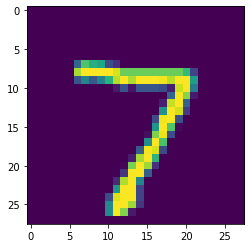

In [14]:
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()